In [0]:
import os
from os import listdir
from os.path import isfile, join
import random
import datetime

from cv2 import imread
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

%load_ext tensorboard
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

TensorFlow 2.x selected.


# NN Classifier with transfer learning

**Objectif :** Use feature extraction and fine-tunning with VGG16

We train only some layers :
* juste head in feature extraction
* head and last convolution layers in fine-tunning

# Import data

Data from my google drive. Then unzip.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import zipfile

with zipfile.ZipFile('/content/drive/My Drive/Data/VET2.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Global variables

In [0]:
FOLDER_PATH = "vet2/"

TRAIN_DATA_PATH = FOLDER_PATH + "train/"
TEST_DATA_PATH = FOLDER_PATH + "train/"
VALID_DATA_PATH = FOLDER_PATH + "valid/"

BATCH_SIZE = 64
TARGET_SIZE = (224, 224)

In [0]:
def imshow(image):
    plt.figure()
    plt.axis("off")
    plt.imshow(image)
    plt.show()


def history_show(history):
    print(history.history.keys())
    plt.figure()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Generators

The pictures are already split in 2 directories, we will use one for train (and validate), the other for test. So, we use flow from directory. 

Suffle the train dataset for better results. On the test dataset, it isn't necessary. The order doesn't influence the accuracy.

Found 2950 images belonging to 8 classes.
Found 517 images belonging to 8 classes.
Found 382 images belonging to 8 classes.
[0. 1. 0. 0. 0. 0. 0. 0.]


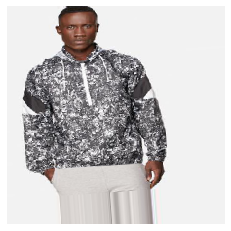

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,   #Scale the image between 0 and 1
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.15
    )

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory=TRAIN_DATA_PATH,
        batch_size=BATCH_SIZE,
        seed=2,
        shuffle=True,
        class_mode="categorical",
        target_size=TARGET_SIZE,
        subset='training'
    )

val_generator = train_datagen.flow_from_directory(
        directory=TRAIN_DATA_PATH,
        batch_size=BATCH_SIZE,
        seed=2,
        shuffle=True,
        class_mode="categorical",
        target_size=TARGET_SIZE,
        subset='validation'
    )

test_generator = val_datagen.flow_from_directory(
        directory=VALID_DATA_PATH,
        batch_size=BATCH_SIZE,
        seed=2,
        shuffle=False,
        class_mode="categorical",
        target_size=TARGET_SIZE
    )

print(train_generator[0][1][0])
imshow(train_generator[0][0][0])

In [0]:
def build_model_1():
    conv_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    conv_base.trainable=False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(8, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])
    model.summary()
    
    return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 520       
Total params: 21,154,440
Trainable params: 6,439,752
Non-trainable params: 14,714,688
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 47 steps, validate for 9 steps
Epoch 1/1

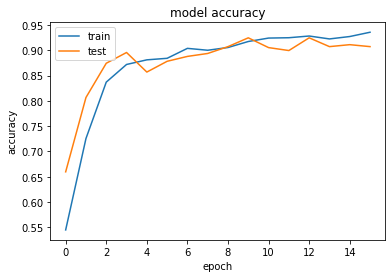

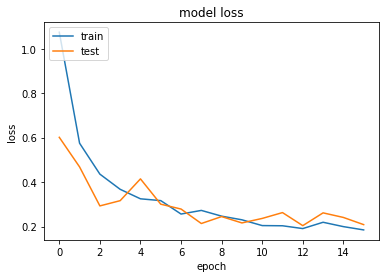

In [0]:
model = build_model_1()

history = model.fit_generator(
        train_generator,
        epochs=24,
        validation_data=val_generator
    )

model.evaluate(test_generator)
history_show(history)

In [0]:
def build_model_2():
    conv_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in conv_base.layers[:-4]:
        layer.trainable = False
    for layer in conv_base.layers:
        print(layer, layer.trainable)


    model = models.Sequential()# (1)
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(8, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])
    model.summary()
    
    return model

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8412439b00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8412408ba8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8412408c18> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8412427128> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8412427208> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f841246ecf8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f84157f4a58> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f84123b1e80> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f84123c5f60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f84123cde80> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f84123cde48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

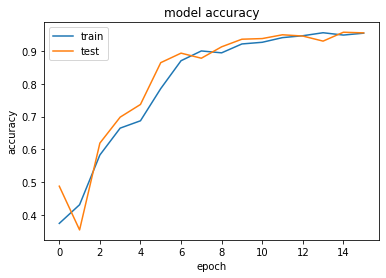

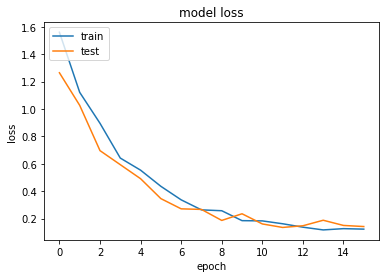

In [0]:
model = build_model_2()

history = model.fit_generator(
        train_generator,
        epochs=24,
        validation_data=val_generator
    )

model.evaluate(test_generator)
history_show(history)